190801 조진욱

3250feats->532 feats using shap[LB: 0.436]

https://www.kaggle.com/youhanlee/3250feats-532-feats-using-shap-lb-0-436

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mkdir -p ~/.kaggle
!cp /content/drive/My\ Drive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [0]:
!pip install kaggle

In [0]:
!kaggle competitions download -c costa-rican-household-poverty-prediction

  0% 0.00/349k [00:00<?, ?B/s]
100% 349k/349k [00:00<00:00, 47.8MB/s]
  0% 0.00/969k [00:00<?, ?B/s]
100% 969k/969k [00:00<00:00, 63.4MB/s]
  0% 0.00/395k [00:00<?, ?B/s]
100% 395k/395k [00:00<00:00, 115MB/s]


In [0]:
!unzip /content/test.csv.zip
!unzip /content/train.csv.zip

Archive:  /content/test.csv.zip
  inflating: test.csv                
Archive:  /content/train.csv.zip
  inflating: train.csv               


# 필사시작



Import
---



In [0]:
!pip install shap

     |████████████████████████████████| 235kB 42.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/00/20/87/d199e4d7397997f5494e4098104f91313ac8120753bee7b032
Successfully built shap


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot  as plt

sns.set(font_scale = 2.2)
plt.style.use('seaborn')

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, ShuffleSplit
from sklearn.metrics import f1_score

import itertools
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier

import shap
from tqdm import tqdm
import featuretools as ft

import warnings
warnings.filterwarnings('ignore')

import time


# Check Datasets



1.1 Read Dataset
---



In [0]:
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')


In [0]:
print('train shape:', df_train.shape, ' ', 'test shape:', df_test.shape)

train shape: (9557, 143)   test shape: (23856, 142)


In [0]:
df_train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,...,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,...,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,...,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,...,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [0]:
df_test.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,...,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,0,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,17,16.5,1,0,0,0,0,0,0,0,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,16,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,17,16.5,0,0,0,0,0,0,0,1,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,1,2,0,1,1,1,2,3,3,3,17,NaN,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,17,16.5,0,0,0,0,0,0,0,0,1,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,16,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,no,16.0,0,0,0,0,0,0,0,1,0,1,1.0,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,11,NaN,0,0,0,0,1,0,0,0,0,2,0.5,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,18,121,324,1,0,1,0.25,64.00,NaN,324



1.2 Make description df
---



In [0]:
description = [
("v2a1"," Monthly rent payment"),
("hacdor"," =1 Overcrowding by bedrooms"),
("rooms","  number of all rooms in the house"),
("hacapo"," =1 Overcrowding by rooms"),
("v14a"," =1 has toilet in the household"),
("refrig"," =1 if the household has refrigerator"),
("v18q"," owns a tablet"),
("v18q1"," number of tablets household owns"),
("r4h1"," Males younger than 12 years of age"),
("r4h2"," Males 12 years of age and older"),
("r4h3"," Total males in the household"),
("r4m1"," Females younger than 12 years of age"),
("r4m2"," Females 12 years of age and older"),
("r4m3"," Total females in the household"),
("r4t1"," persons younger than 12 years of age"),
("r4t2"," persons 12 years of age and older"),
("r4t3"," Total persons in the household"),
("tamhog"," size of the household"),
("tamviv"," number of persons living in the household"),
("escolari"," years of schooling"),
("rez_esc"," Years behind in school"),
("hhsize"," household size"),
("paredblolad"," =1 if predominant material on the outside wall is block or brick"),
("paredzocalo"," =1 if predominant material on the outside wall is socket (wood, zinc or absbesto"),
("paredpreb"," =1 if predominant material on the outside wall is prefabricated or cement"),
("pareddes"," =1 if predominant material on the outside wall is waste material"),
("paredmad"," =1 if predominant material on the outside wall is wood"),
("paredzinc"," =1 if predominant material on the outside wall is zink"),
("paredfibras"," =1 if predominant material on the outside wall is natural fibers"),
("paredother"," =1 if predominant material on the outside wall is other"),
("pisomoscer"," =1 if predominant material on the floor is mosaic ceramic   terrazo"),
("pisocemento"," =1 if predominant material on the floor is cement"),
("pisoother"," =1 if predominant material on the floor is other"),
("pisonatur"," =1 if predominant material on the floor is  natural material"),
("pisonotiene"," =1 if no floor at the household"),
("pisomadera"," =1 if predominant material on the floor is wood"),
("techozinc"," =1 if predominant material on the roof is metal foil or zink"),
("techoentrepiso"," =1 if predominant material on the roof is fiber cement,   mezzanine "),
("techocane"," =1 if predominant material on the roof is natural fibers"),
("techootro"," =1 if predominant material on the roof is other"),
("cielorazo"," =1 if the house has ceiling"),
("abastaguadentro"," =1 if water provision inside the dwelling"),
("abastaguafuera"," =1 if water provision outside the dwelling"),
("abastaguano"," =1 if no water provision"),
("public"," =1 electricity from CNFL,  ICE, ESPH/JASEC"),
("planpri"," =1 electricity from private plant"),
("noelec"," =1 no electricity in the dwelling"),
("coopele"," =1 electricity from cooperative"),
("sanitario1"," =1 no toilet in the dwelling"),
("sanitario2"," =1 toilet connected to sewer or cesspool"),
("sanitario3"," =1 toilet connected to  septic tank"),
("sanitario5"," =1 toilet connected to black hole or letrine"),
("sanitario6"," =1 toilet connected to other system"),
("energcocinar1"," =1 no main source of energy used for cooking (no kitchen)"),
("energcocinar2"," =1 main source of energy used for cooking electricity"),
("energcocinar3"," =1 main source of energy used for cooking gas"),
("energcocinar4"," =1 main source of energy used for cooking wood charcoal"),
("elimbasu1"," =1 if rubbish disposal mainly by tanker truck"),
("elimbasu2"," =1 if rubbish disposal mainly by botan hollow or buried"),
("elimbasu3"," =1 if rubbish disposal mainly by burning"),
("elimbasu4"," =1 if rubbish disposal mainly by throwing in an unoccupied space"),
("elimbasu5"," =1 if rubbish disposal mainly by throwing in river,   creek or sea"),
("elimbasu6"," =1 if rubbish disposal mainly other"),
("epared1"," =1 if walls are bad"),
("epared2"," =1 if walls are regular"),
("epared3"," =1 if walls are good"),
("etecho1"," =1 if roof are bad"),
("etecho2"," =1 if roof are regular"),
("etecho3"," =1 if roof are good"),
("eviv1"," =1 if floor are bad"),
("eviv2"," =1 if floor are regular"),
("eviv3"," =1 if floor are good"),
("dis"," =1 if disable person"),
("male"," =1 if male"),
("female"," =1 if female"),
("estadocivil1"," =1 if less than 10 years old"),
("estadocivil2"," =1 if free or coupled uunion"),
("estadocivil3"," =1 if married"),
("estadocivil4"," =1 if divorced"),
("estadocivil5"," =1 if separated"),
("estadocivil6"," =1 if widow/er"),
("estadocivil7"," =1 if single"),
("parentesco1"," =1 if household head"),
("parentesco2"," =1 if spouse/partner"),
("parentesco3"," =1 if son/doughter"),
("parentesco4"," =1 if stepson/doughter"),
("parentesco5"," =1 if son/doughter in law"),
("parentesco6"," =1 if grandson/doughter"),
("parentesco7"," =1 if mother/father"),
("parentesco8"," =1 if father/mother in law"),
("parentesco9"," =1 if brother/sister"),
("parentesco10"," =1 if brother/sister in law"),
("parentesco11"," =1 if other family member"),
("parentesco12"," =1 if other non family member"),
("idhogar"," Household level identifier"),
("hogar_nin"," Number of children 0 to 19 in household"),
("hogar_adul"," Number of adults in household"),
("hogar_mayor"," # of individuals 65+ in the household"),
("hogar_total"," # of total individuals in the household"),
("dependency"," Dependency rate"),
("edjefe"," years of education of male head of household"),
("edjefa"," years of education of female head of household"),
("meaneduc","average years of education for adults (18+)"),
("instlevel1"," =1 no level of education"),
("instlevel2"," =1 incomplete primary"),
("instlevel3"," =1 complete primary"),
("instlevel4"," =1 incomplete academic secondary level"),
("instlevel5"," =1 complete academic secondary level"),
("instlevel6"," =1 incomplete technical secondary level"),
("instlevel7"," =1 complete technical secondary level"),
("instlevel8"," =1 undergraduate and higher education"),
("instlevel9"," =1 postgraduate higher education"),
("bedrooms"," number of bedrooms"),
("overcrowding"," # persons per room"),
("tipovivi1"," =1 own and fully paid house"),
("tipovivi2"," =1 own,   paying in installments"),
("tipovivi3"," =1 rented"),
("tipovivi4"," =1 precarious"),
("tipovivi5"," =1 other(assigned"),
("computer"," =1 if the household has notebook or desktop computer,   borrowed)"),
("television"," =1 if the household has TV"),
("mobilephone"," =1 if mobile phone"),
("qmobilephone"," # of mobile phones"),
("lugar1"," =1 region Central"),
("lugar2"," =1 region Chorotega"),
("lugar3"," =1 region PacÃƒÂ­fico central"),
("lugar4"," =1 region Brunca"),
("lugar5"," =1 region Huetar AtlÃƒÂ¡ntica"),
("lugar6"," =1 region Huetar Norte"),
("area1"," =1 zona urbana"),
("area2"," =2 zona rural"),
("age"," Age in years"),
("SQBescolari"," escolari squared"),
("SQBage"," age squared"),
("SQBhogar_total"," hogar_total squared"),
("SQBedjefe"," edjefe squared"),
("SQBhogar_nin"," hogar_nin squared"),
("SQBovercrowding"," overcrowding squared"),
("SQBdependency"," dependency squared"),
("SQBmeaned"," meaned squared"),
("agesq"," Age squared"),]

description = pd.DataFrame(description, columns=['varname', 'description'])

In [0]:
description

,varname,description
0,v2a1,Monthly rent payment
1,hacdor,=1 Overcrowding by bedrooms
2,rooms,number of all rooms in the house
3,hacapo,=1 Overcrowding by rooms
4,v14a,=1 has toilet in the household
5,refrig,=1 if the household has refrigerator
6,v18q,owns a tablet
7,v18q1,number of tablets household owns
8,r4h1,Males younger than 12 years of age
9,r4h2,Males 12 years of age and older



1.3 Check Null data
---



In [0]:
total = df_train.isnull().sum().sort_values(ascending = False)
percent = 100* (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending=False)
missing_df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_df.head(20)


,Total,Percent
rez_esc,7928,82.954902
v18q1,7342,76.823271
v2a1,6860,71.779847
meaneduc,5,0.052318
SQBmeaned,5,0.052318
techozinc,0,0.000000
techoentrepiso,0,0.000000
techocane,0,0.000000
techootro,0,0.000000
cielorazo,0,0.000000



(+) Pandas Indexing practice
---



In [0]:
description.loc[description['varname'] == 'escolari', 'description']

19     years of schooling
Name: description, dtype: object

In [0]:
description[description['varname'] == 'edjefa']['description']

101     years of education of female head of household
Name: description, dtype: object

In [0]:
description[description['varname'] == 'edjefe']['description']

100     years of education of male head of household
Name: description, dtype: object


1.4 Fill missing values
---



In [0]:
df_train['edjefa'].nunique()

22

In [0]:
df_train[df_train['edjefa'] == 'yes']['edjefa'].count()

69

In [0]:
df_train[df_train['edjefa'] == 'no']['edjefa'].count()

6230

In [0]:
df_train.loc[(df_train['edjefa'] != "yes") & (df_train['edjefa'] != "no"), "edjefa"].nunique()

20

In [0]:
# edjefa 는 여자 edjefa 는 남자가 그 집안의 가장일 때 그 사람의 교육 수준. years 인데 왠진 몰라도 'yes' 'no' 가 있음
df_train.loc[(df_train['edjefa'] == "yes") & (df_train['parentesco1'] == 1), "edjefa"] = df_train.loc[(df_train['edjefa'] == "yes") & (df_train['parentesco1'] == 1), "escolari"]
df_train.loc[(df_train['edjefe'] == "yes") & (df_train['parentesco1'] == 1), "edjefe"] = df_train.loc[(df_train['edjefe'] == "yes") & (df_train['parentesco1'] == 1), "escolari"]

df_test.loc[(df_test['edjefa'] == "yes") & (df_test['parentesco1'] == 1), "edjefa"] = df_test.loc[(df_test['edjefa'] == "yes") & (df_test['parentesco1'] == 1), "escolari"]
df_test.loc[(df_test['edjefe'] == "yes") & (df_test['parentesco1'] == 1), "edjefe"] = df_test.loc[(df_test['edjefe'] == "yes") & (df_test['parentesco1'] == 1), "escolari"]

In [0]:
# 어떤기준인지 도저히 모르겠는데 yes 인 사람들을 그냥 4 로 바꿈
df_train.loc[df_train['edjefa'] == "yes", "edjefa"] = 4
df_train.loc[df_train['edjefe'] == "yes", "edjefe"] = 4

df_test.loc[df_test['edjefa'] == "yes", "edjefa"] = 4
df_test.loc[df_test['edjefe'] == "yes", "edjefe"] = 4

In [0]:
df_train['edjef'] = np.max(df_train[['edjefa','edjefe']], axis=1)
df_test['edjef'] = np.max(df_test[['edjefa','edjefe']], axis=1)

no water = no toilet

In [0]:
description.loc[description['varname'] == 'abastaguano', 'description']

43     =1 if no water provision
Name: description, dtype: object

In [0]:
df_train.loc[(df_train.v14a ==  1) & (df_train.sanitario1 ==  1) & (df_train.abastaguano == 0), "v14a"] = 0
df_train.loc[(df_train.v14a ==  1) & (df_train.sanitario1 ==  1) & (df_train.abastaguano == 0), "sanitario1"] = 0

df_test.loc[(df_test.v14a ==  1) & (df_test.sanitario1 ==  1) & (df_test.abastaguano == 0), "v14a"] = 0
df_test.loc[(df_test.v14a ==  1) & (df_test.sanitario1 ==  1) & (df_test.abastaguano == 0), "sanitario1"] = 0

rez_esz, SQBmeaned, meaneduc


rez_esc : Years behind in school -> filled with 0


SQBmeaned : square of the mean years of education of adults (>=18) in the household agesq, Age squared -> same with rez_esc -> filled with 0


meaneduc: average years of education for adults (18+) -> filled with 0

In [0]:
description.loc[description['varname'] == 'meaneduc', 'description']

102    average years of education for adults (18+)
Name: description, dtype: object

In [0]:
df_train['rez_esc'].fillna(0, inplace=True)
df_test['rez_esc'].fillna(0, inplace=True)

In [0]:
df_train['SQBmeaned'].fillna(0, inplace=True)
df_test['SQBmeaned'].fillna(0, inplace=True)

In [0]:
df_train['meaneduc'].fillna(0, inplace=True)
df_test['meaneduc'].fillna(0, inplace=True)

v18q1

In [0]:
description.loc[description['varname'] == 'v18q1', 'description']

7     number of tablets household owns
Name: description, dtype: object

In [0]:
df_train['v18q'].value_counts()

0    7342
1    2215
Name: v18q, dtype: int64

In [0]:
df_train.loc[df_train['v18q'] == 1, 'v18q1'].value_counts()

1.0    1586
2.0     444
3.0     129
4.0      37
5.0      13
6.0       6
Name: v18q1, dtype: int64

In [0]:
df_train.loc[df_train['v18q'] == 0, 'v18q1'].value_counts() 

Series([], Name: v18q1, dtype: int64)

In [0]:
df_train['v18q1'].fillna(0, inplace=True)
df_test['v18q1'].fillna(0, inplace=True)

v2a1

In [0]:
description.loc[description['varname'] == 'v2a1', 'description']

0     Monthly rent payment
Name: description, dtype: object

In [0]:
description.loc[description['varname'] == 'tipovivi1', 'description']

114     =1 own and fully paid house
Name: description, dtype: object

In [0]:
df_train['tipovivi3'].value_counts()

0    7821
1    1736
Name: tipovivi3, dtype: int64

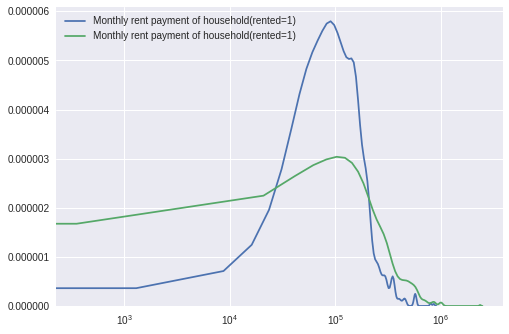

In [0]:
sns.kdeplot(df_train.loc[df_train['tipovivi3'] == 1, 'v2a1'], label = 'Monthly rent payment of household(rented=1)')
sns.kdeplot(df_train.loc[df_train['tipovivi3'] == 0, 'v2a1'], label = 'Monthly rent payment of household(rented=1)')
plt.xscale('log')
plt.show()

In [0]:
df_train['v2a1'].fillna(0, inplace=True)
df_test['v2a1'].fillna(0, inplace=True)

In [0]:
total = df_train.isnull().sum().sort_values(ascending=False)

percent = 100 * (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending=False)
missing_df = pd.concat([total, percent], axis =1, keys = ['Total', 'Percent'])
missing_df.head()

,Total,Percent
edjef,9557,100.0
Target,0,0.0
sanitario3,0,0.0
sanitario2,0,0.0
sanitario1,0,0.0


In [0]:
total = df_test.isnull().sum().sort_values(ascending=False)

percent = 100 * (df_test.isnull().sum() / df_test.isnull().count()).sort_values(ascending=False)
missing_df = pd.concat([total, percent], axis =1, keys = ['Total', 'Percent'])
missing_df.head()

,Total,Percent
edjef,23856,100.0
abastaguano,0,0.0
sanitario2,0,0.0
sanitario1,0,0.0
coopele,0,0.0


# 2. Feature Engineering


2.1 Object Features replacement
---



object features 탐지

In [0]:
features_object = [col for col in df_train.columns if df_train[col].dtype == 'object']

In [0]:
features_object

['Id', 'idhogar', 'dependency', 'edjefe', 'edjefa']

dependency

In [0]:
df_train['dependency'] = np.sqrt(df_train['SQBdependency'])
df_test['dependency'] = np.sqrt(df_test['SQBdependency'])

추가:  yes 이거나 no 일때 10 과 0, inf value 는 0으로 

In [0]:
df_train['dependency'] = df_train['dependency'].replace({np.inf: 0})
df_test['dependency'] = df_test['dependency'].replace({np.inf: 0})

def replace_dependency(x):
    if x == 'yes':
        return 10
    elif x == 'no':
        return 0
    else:
        return x

df_train['dependency'] = df_train['dependency'].apply(replace_dependency).astype(float)
df_test['dependency'] = df_test['dependency'].apply(replace_dependency).astype(float)

edjefe

In [0]:
def replace_edjefe(x):
    if x == 'yes':
        return 1
    elif x == 'no':
        return 0
    else:
        return x
    
df_train['edjefe'] = df_train['edjefe'].apply(replace_edjefe).astype(float)   
df_test['edjefe'] = df_train['edjefe'].apply(replace_edjefe).astype(float)


edjefa

In [0]:
def replace_edjefa(x):
    if x == 'yes':
        return 1
    elif x == 'no':
        return 0
    else:
        return x
    
df_train['edjefa'] = df_train['edjefa'].apply(replace_edjefa).astype(float)   
df_test['edjefa'] = df_train['edjefa'].apply(replace_edjefa).astype(float)


In [0]:
df_train['edjef'] = np.max(df_train[['edjefa','edjefe']], axis=1)
df_test['edjef'] = np.max(df_test[['edjefa','edjefe']], axis=1)

roof and electricity


In [0]:
df_train['roof_waste_material'] = np.nan
df_test['roof_waste_material'] = np.nan
df_train['electricity_other'] = np.nan
df_test['electricity_other'] = np.nan

def fill_roof_exception(x):
    if (x['techozinc'] == 0) and (x['techoentrepiso'] == 0) and (x['techocane'] == 0) and (x['techootro'] == 0):
        return 1
    else:
        return 0

def fill_no_electricity(x):
    if (x['public'] == 0) and (x['planpri'] == 0) and (x['noelec'] == 0) and (x['coopele'] == 0):
        return 1
    else:
        return 0    

In [0]:
df_train['roof_waste_material'] = df_train.apply(lambda x: fill_roof_exception(x), axis = 1)
df_test['roof_waste_material'] = df_test.apply(lambda x: fill_roof_exception(x), axis = 1)

df_train['electricity_other'] = df_train.apply(lambda x: fill_no_electricity(x), axis = 1)
df_test['electricity_other'] = df_test.apply(lambda x: fill_no_electricity(x), axis = 1)


2.2 Extract cat features
---



In [0]:
binary_cat_features = [col for col in df_train.columns if df_train[col].value_counts().shape[0] == 2]

In [0]:
binary_cat_features

['hacdor',
 'hacapo',
 'v14a',
 'refrig',
 'v18q',
 'paredblolad',
 'paredzocalo',
 'paredpreb',
 'pareddes',
 'paredmad',
 'paredzinc',
 'paredfibras',
 'paredother',
 'pisomoscer',
 'pisocemento',
 'pisoother',
 'pisonatur',
 'pisonotiene',
 'pisomadera',
 'techozinc',
 'techoentrepiso',
 'techocane',
 'techootro',
 'cielorazo',
 'abastaguadentro',
 'abastaguafuera',
 'abastaguano',
 'public',
 'planpri',
 'noelec',
 'coopele',
 'sanitario1',
 'sanitario2',
 'sanitario3',
 'sanitario5',
 'sanitario6',
 'energcocinar1',
 'energcocinar2',
 'energcocinar3',
 'energcocinar4',
 'elimbasu1',
 'elimbasu2',
 'elimbasu3',
 'elimbasu4',
 'elimbasu6',
 'epared1',
 'epared2',
 'epared3',
 'etecho1',
 'etecho2',
 'etecho3',
 'eviv1',
 'eviv2',
 'eviv3',
 'dis',
 'male',
 'female',
 'estadocivil1',
 'estadocivil2',
 'estadocivil3',
 'estadocivil4',
 'estadocivil5',
 'estadocivil6',
 'estadocivil7',
 'parentesco1',
 'parentesco2',
 'parentesco3',
 'parentesco4',
 'parentesco5',
 'parentesco6',
 'parentesco7',
 'parentesco8',
 'parentesco9',
 'parentesco10',
 'parentesco11',
 'parentesco12',
 'instlevel1',
 'instlevel2',
 'instlevel3',
 'instlevel4',
 'instlevel5',
 'instlevel6',
 'instlevel7',
 'instlevel8',
 'instlevel9',
 'tipovivi1',
 'tipovivi2',
 'tipovivi3',
 'tipovivi4',
 'tipovivi5',
 'computer',
 'television',
 'mobilephone',
 'lugar1',
 'lugar2',
 'lugar3',
 'lugar4',
 'lugar5',
 'lugar6',
 'area1',
 'area2',
 'roof_waste_material',
 'electricity_other']


2.3 Make new features using continuous feature
---



In [0]:
# Cont features 를 찾기 위해 binary 제거 / object 제거 / Target 제거
continuous_features = [col for col in df_train.columns if col not in binary_cat_features]
continuous_features = [col for col in continuous_features if col not in features_object]
continuous_features = [col for col in continuous_features if col not in ['Id', 'Target', 'idhogar']] 
# 왜 여기서 Id, idhogar 을 추가하지? 

In [0]:
print('There are {} continuous features'.format(len(continuous_features)))
for col in continuous_features:
    print('{}: {}'.format(col, description.loc[description['varname'] == col, 'description'].values))

There are 37 continuous features
v2a1: [' Monthly rent payment']
rooms: ['  number of all rooms in the house']
v18q1: [' number of tablets household owns']
r4h1: [' Males younger than 12 years of age']
r4h2: [' Males 12 years of age and older']
r4h3: [' Total males in the household']
r4m1: [' Females younger than 12 years of age']
r4m2: [' Females 12 years of age and older']
r4m3: [' Total females in the household']
r4t1: [' persons younger than 12 years of age']
r4t2: [' persons 12 years of age and older']
r4t3: [' Total persons in the household']
tamhog: [' size of the household']
tamviv: [' number of persons living in the household']
escolari: [' years of schooling']
rez_esc: [' Years behind in school']
hhsize: [' household size']
elimbasu5: [' =1 if rubbish disposal mainly by throwing in river,   creek or sea']
hogar_nin: [' Number of children 0 to 19 in household']
hogar_adul: [' Number of adults in household']
hogar_mayor: [' # of individuals 65+ in the household']
hogar_total: [

hhsize 랑 tamhog 가 같은 피쳐이므로 하나를 drop 하기로 함

In [0]:
df_train['edjef'].value_counts()

6.0     2792
11.0    1150
9.0      723
8.0      474
15.0     473
3.0      459
0.0      435
7.0      413
4.0      400
5.0      398
14.0     328
17.0     278
2.0      278
16.0     247
10.0     207
12.0     185
13.0     155
1.0       65
21.0      48
18.0      22
19.0      18
20.0       9
Name: edjef, dtype: int64

In [0]:
df_train.drop('tamhog', axis=1, inplace=True)
df_test.drop('tamhog', axis=1, inplace=True)

Squared features

트리 모델(lgbm) 같은 건 squared features 필요 없음. 그러나 이 커널에서는 lgbm 을 feature filter model 이자 entity-embedding 으로 classifier 로 지정하고자 함. 그래서 남김.



Family features

hogar_nin, hogar_adul, hogar_mayor, hogar_total, r4h1, r4h2, r4h3, r4m1, r4m2, r4m3, r4t1, r4t2, r4t3, tmbhog, tamvid, rez_esc, escolari
Family size features (substract, ratio)


In [0]:
df_train['adult'] = df_train['hogar_adul'] - df_train['hogar_mayor']
df_train['dependency_count'] = df_train['hogar_nin'] + df_train['hogar_mayor']
df_train['dependency'] = df_train['dependency_count'] / df_train['adult']
df_train['child_percent'] = df_train['hogar_nin'] / df_train['hogar_total']
df_train['elder_percent'] = df_train['hogar_mayor'] / df_train['hogar_total']
df_train['adult_percent'] = df_train['hogar_adul'] / df_train['hogar_total']
df_train['males_younger_12_years_percent'] = df_train['r4h1'] / df_train['hogar_total']
df_train['males_older_12_years_percent'] = df_train['r4h2'] / df_train['hogar_total']
df_train['males_percent'] = df_train['r4h3'] / df_train['hogar_total']
df_train['females_younger_12_years_percent'] = df_train['r4m1'] / df_train['hogar_total']
df_train['females_older_12_years_percent'] = df_train['r4m2'] / df_train['hogar_total']
df_train['females_percent'] = df_train['r4m3'] / df_train['hogar_total']
df_train['persons_younger_12_years_percent'] = df_train['r4t1'] / df_train['hogar_total']
df_train['persons_older_12_years_percent'] = df_train['r4t2'] / df_train['hogar_total']
df_train['persons_percent'] = df_train['r4t3'] / df_train['hogar_total']

똑같이 test에도

In [0]:
df_test['adult'] = df_test['hogar_adul'] - df_test['hogar_mayor']
df_test['dependency_count'] = df_test['hogar_nin'] + df_test['hogar_mayor']
df_test['dependency'] = df_test['dependency_count'] / df_test['adult']
df_test['child_percent'] = df_test['hogar_nin'] / df_test['hogar_total']
df_test['elder_percent'] = df_test['hogar_mayor'] / df_test['hogar_total']
df_test['adult_percent'] = df_test['hogar_adul'] / df_test['hogar_total']
df_test['males_younger_12_years_percent'] = df_test['r4h1'] / df_test['hogar_total']
df_test['males_older_12_years_percent'] = df_test['r4h2'] / df_test['hogar_total']
df_test['males_percent'] = df_test['r4h3'] / df_test['hogar_total']
df_test['females_younger_12_years_percent'] = df_test['r4m1'] / df_test['hogar_total']
df_test['females_older_12_years_percent'] = df_test['r4m2'] / df_test['hogar_total']
df_test['females_percent'] = df_test['r4m3'] / df_test['hogar_total']
df_test['persons_younger_12_years_percent'] = df_test['r4t1'] / df_test['hogar_total']
df_test['persons_older_12_years_percent'] = df_test['r4t2'] / df_test['hogar_total']
df_test['persons_percent'] = df_test['r4t3'] / df_test['hogar_total']

In [0]:
df_train['males_younger_12_years_in_household_size'] = df_train['r4h1'] / df_train['hhsize']
df_train['males_older_12_years_in_household_size'] = df_train['r4h2'] / df_train['hhsize']
df_train['males_in_household_size'] = df_train['r4h3'] / df_train['hhsize']
df_train['females_younger_12_years_in_household_size'] = df_train['r4m1'] / df_train['hhsize']
df_train['females_older_12_years_in_household_size'] = df_train['r4m2'] / df_train['hhsize']
df_train['females_in_household_size'] = df_train['r4m3'] / df_train['hogar_total']
df_train['persons_younger_12_years_in_household_size'] = df_train['r4t1'] / df_train['hhsize']
df_train['persons_older_12_years_in_household_size'] = df_train['r4t2'] / df_train['hhsize']
df_train['persons_in_household_size'] = df_train['r4t3'] / df_train['hhsize']

In [0]:
df_test['males_younger_12_years_in_household_size'] = df_test['r4h1'] / df_test['hhsize']
df_test['males_older_12_years_in_household_size'] = df_test['r4h2'] / df_test['hhsize']
df_test['males_in_household_size'] = df_test['r4h3'] / df_test['hhsize']
df_test['females_younger_12_years_in_household_size'] = df_test['r4m1'] / df_test['hhsize']
df_test['females_older_12_years_in_household_size'] = df_test['r4m2'] / df_test['hhsize']
df_test['females_in_household_size'] = df_test['r4m3'] / df_test['hogar_total']
df_test['persons_younger_12_years_in_household_size'] = df_test['r4t1'] / df_test['hhsize']
df_test['persons_older_12_years_in_household_size'] = df_test['r4t2'] / df_test['hhsize']
df_test['persons_in_household_size'] = df_test['r4t3'] / df_test['hhsize']

In [0]:
df_train['overcrowding_room_and_bedroom'] = (df_train['hacdor'] + df_train['hacapo'])/2
df_test['overcrowding_room_and_bedroom'] = (df_test['hacdor'] + df_test['hacapo'])/2

In [0]:
df_train['escolari_age'] = df_train['escolari']/df_train['age']
df_test['escolari_age'] = df_test['escolari']/df_test['age']

df_train['age_12_19'] = df_train['hogar_nin'] - df_train['r4t1']
df_test['age_12_19'] = df_test['hogar_nin'] - df_test['r4t1'] 

In [0]:
df_train['phones-per-capita'] = df_train['qmobilephone'] / df_train['tamviv']
df_train['tablets-per-capita'] = df_train['v18q1'] / df_train['tamviv']
df_train['rooms-per-capita'] = df_train['rooms'] / df_train['tamviv']
df_train['rent-per-capita'] = df_train['v2a1'] / df_train['tamviv']

In [0]:
df_test['phones-per-capita'] = df_test['qmobilephone'] / df_test['tamviv']
df_test['tablets-per-capita'] = df_test['v18q1'] / df_test['tamviv']
df_test['rooms-per-capita'] = df_test['rooms'] / df_test['tamviv']
df_test['rent-per-capita'] = df_test['v2a1'] / df_test['tamviv']

In [0]:
(df_train['hogar_total'] == df_train['r4t3']).sum()

9509

Rent per family features

In [0]:
family_size_features = ['adult', 'hogar_adul', 'hogar_mayor', 'hogar_nin', 'hogar_total', 'r4h1', 
                        'r4h2', 'r4h3', 'r4m1', 'r4m2', 'r4m3', 'r4t1', 'r4t2', 'r4t3', 'hhsize']
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('v2a1', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['v2a1'] / df_train[col]
    df_test[new_col_name] = df_test['v2a1'] / df_test[col]

ratio 피쳐를 0 으로 채워넣기

replace 를 먼저 해서 inf 를 nan 으로 바꾸고 fillna를 사용

In [0]:
for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

Room per family 만들기// Bedroom per family

In [0]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('rooms', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['rooms'] / df_train[col]
    df_test[new_col_name] = df_test['rooms'] / df_test[col]

for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

In [0]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('bedrooms', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['bedrooms'] / df_train[col]
    df_test[new_col_name] = df_test['bedrooms'] / df_test[col]

for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

shape 체크

In [0]:
print(df_train.shape, df_test.shape)

(9557, 220) (23856, 219)


가족당 tabulet 대수 , 폰 대수

In [0]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('v18q1', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['v18q1'] / df_train[col]
    df_test[new_col_name] = df_test['v18q1'] / df_test[col]

for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

In [0]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('qmobilephone', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['qmobilephone'] / df_train[col]
    df_test[new_col_name] = df_test['qmobilephone'] / df_test[col]

for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

years behind school 가족당 얼마인지 

In [0]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('rez_esc', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['rez_esc'] / df_train[col]
    df_test[new_col_name] = df_test['rez_esc'] / df_test[col]

for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

In [0]:
description.loc[description['varname'] == 'escolari', 'description']

19     years of schooling
Name: description, dtype: object

In [0]:
df_train['rez_esc_age'] = df_train['rez_esc'] / df_train['age']
df_train['rez_esc_escolari'] = df_train['rez_esc'] / df_train['escolari']

df_test['rez_esc_age'] = df_test['rez_esc'] / df_test['age']
df_test['rez_esc_escolari'] = df_test['rez_esc'] / df_test['escolari']


2.3.2 Rich features
---



In [0]:
df_train['tabulet_x_qmobilephone'] = df_train['v18q1'] * df_train['qmobilephone']
df_test['tabulet_x_qmobilephone'] = df_test['v18q1'] * df_test['qmobilephone']

In [0]:
# wall and roof
for col1 in ['epared1', 'epared2', 'epared3']:
    for col2 in ['etecho1', 'etecho2', 'etecho3']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]
        
# wall and floor
for col1 in ['epared1', 'epared2', 'epared3']:
    for col2 in ['eviv1', 'eviv2', 'eviv3']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

# roof and floor
for col1 in ['etecho1', 'etecho2', 'etecho3']:
    for col2 in ['eviv1', 'eviv2', 'eviv3']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

In [0]:
for col1 in ['epared1', 'epared2', 'epared3']:
    for col2 in ['etecho1', 'etecho2', 'etecho3']:
        for col3 in ['eviv1', 'eviv2', 'eviv3']:
            new_col_name = 'new_{}_x_{}_x_{}'.format(col1, col2, col3)
            df_train[new_col_name] = df_train[col1] * df_train[col2] * df_train[col3]
            df_test[new_col_name] = df_test[col1] * df_test[col2] * df_train[col3]

In [0]:
print(df_train.shape, df_test.shape)

(9557, 322) (23856, 321)


결국 지금 새로운 feature 을 생성하는 원리는 단순히 df 열들의 단순한 스칼라 곱을 포문에 의해 진행하는 식으로 이루어짐. 

이번엔 electricity 와 energy -> energy, toilet 과  rubbish disposal 을 other infra, toilet 과 water provision 을 water 로 새로 만들고자함

In [0]:
for col1 in ['public', 'planpri', 'noelec', 'coopele']:
    for col2 in ['energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

In [0]:
for col1 in ['sanitario1', 'sanitario2', 'sanitario3', 'sanitario5', 'sanitario6']:
    for col2 in ['elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 'elimbasu5', 'elimbasu6']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

In [0]:
for col1 in ['abastaguadentro', 'abastaguafuera', 'abastaguano']:
    for col2 in ['sanitario1', 'sanitario2', 'sanitario3', 'sanitario5', 'sanitario6']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

In [0]:
print(df_train.shape, df_test.shape)

(9557, 383) (23856, 382)


교육과 영역 정보를 합쳐서 education zone 으로. 근데 이 둘을 그냥 곱해도 되나 ? --> binary 라서 괜찮나봄

In [0]:
description.loc[description['varname'] == 'instlevel1', 'description']

103     =1 no level of education
Name: description, dtype: object

In [0]:
for col1 in ['area1', 'area2']:
    for col2 in ['instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

In [0]:
for col1 in ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']:
    for col2 in ['instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

In [0]:
print(df_train.shape, df_test.shape)

(9557, 455) (23856, 454)


In [0]:
df_train['electronics'] = df_train['computer'] * df_train['mobilephone'] * df_train['television'] * df_train['v18q'] * df_train['refrig']
df_test['electronics'] = df_test['computer'] * df_test['mobilephone'] * df_test['television'] * df_test['v18q'] * df_test['refrig']

df_train['no_appliances'] = df_train['refrig'] + df_train['computer'] + df_train['television'] + df_train['mobilephone']
df_test['no_appliances'] = df_test['refrig'] + df_test['computer'] + df_test['television'] + df_test['mobilephone']

In [0]:
for col1 in ['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad', 'paredzinc', 'paredfibras', 'paredother']:
    for col2 in ['pisomoscer', 'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

for col1 in ['pisomoscer', 'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera']:
    for col2 in ['techozinc', 'techoentrepiso', 'techocane', 'techootro']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]
        
for col1 in ['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad', 'paredzinc', 'paredfibras', 'paredother']:
    for col2 in ['techozinc', 'techoentrepiso', 'techocane', 'techootro']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]        
        
for col1 in ['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad', 'paredzinc', 'paredfibras', 'paredother']:
    for col2 in ['pisomoscer', 'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera']:
        for col3 in ['techozinc', 'techoentrepiso', 'techocane', 'techootro']:
            new_col_name = 'new_{}_x_{}_x_{}'.format(col1, col2, col3)
            df_train[new_col_name] = df_train[col1] * df_train[col2] * df_train[col3]
            df_test[new_col_name] = df_test[col1] * df_test[col2] * df_train[col3]

In [0]:
print(df_train.shape, df_test.shape)

(9557, 733) (23856, 732)


열심히 만든 피쳐에서 하나만 값이 있는 것 들은 지우기. 즉 대부분의 경우 모든 값이 0으로 나온 애들은 지우겠다는 소리

In [0]:
df_train['elimbasu5'].value_counts()

0    9557
Name: elimbasu5, dtype: int64

In [0]:
cols_with_only_one_value = []
for col in df_train.columns:
    if col == 'Target':
        continue
    if df_train[col].value_counts().shape[0] == 1 or df_test[col].value_counts().shape[0] == 1:
        print(col)
        cols_with_only_one_value.append(col)

In [0]:
df_train.drop(cols_with_only_one_value, axis=1, inplace=True)
df_test.drop(cols_with_only_one_value, axis=1, inplace=True)

In [0]:
cols_train = np.array(sorted([col for col in df_train.columns if col != 'Target']))
cols_test = np.array(sorted(df_test.columns))

In [0]:
len(cols_train)

515

In [0]:
(cols_train == cols_test).sum()

515

In [0]:
(cols_train == cols_test).sum() == len(cols_train)

True


2.4 Aggregation features
---

aggregate based on 'idhogar' values.

In [0]:
def max_min(x):
    return x.max() - x.min()

tqdm 은 progress 를 보여주는 라이브러리 
https://github.com/tqdm/tqdm

In [0]:
agg_train = pd.DataFrame()
agg_test = pd.DataFrame()

for item in tqdm(family_size_features):
    for i, function in enumerate(['mean', 'std', 'min', 'max', 'sum', 'count', max_min]):
        group_train = df_train[item].groupby(df_train['idhogar']).agg(function)
        group_test = df_test[item].groupby(df_test['idhogar']).agg(function)
        if i == 6:
            new_col = item + '_new_' + 'max_min'
        else:
            new_col = item + '_new_' + function
        agg_train[new_col] = group_train
        agg_test[new_col] = group_test
        
print('new aggregate train set has {} rows, and {} features'.format(agg_train.shape[0], agg_train.shape[1]))
print('new aggregate test set has {} rows, and {} features'.format(agg_test.shape[0], agg_test.shape[1]))

100%|██████████| 15/15 [00:26<00:00,  1.74s/it]

new aggregate train set has 2988 rows, and 105 features
new aggregate test set has 7352 rows, and 105 features


In [0]:
aggr_list = ['rez_esc', 'dis', 'male', 'female', 
             'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
             'parentesco2', 'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 
             'parentesco11', 'parentesco12',
             'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9',
             'epared1', 'epared2', 'epared3', 'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 'refrig', 'television', 'mobilephone',
             'area1', 'area2', 'v18q', 'edjef']

for item in tqdm(aggr_list):
    for function in ['count', 'sum']:
        group_train = df_train[item].groupby(df_train['idhogar']).agg(function)
        group_test = df_test[item].groupby(df_test['idhogar']).agg(function)
        new_col = item + '_new1_' + function
        agg_train[new_col] = group_train
        agg_test[new_col] = group_test
print('new aggregate train set has {} rows, and {} features'.format(agg_train.shape[0], agg_train.shape[1]))
print('new aggregate test set has {} rows, and {} features'.format(agg_test.shape[0], agg_test.shape[1]))

100%|██████████| 47/47 [00:01<00:00, 31.91it/s]

new aggregate train set has 2988 rows, and 199 features
new aggregate test set has 7352 rows, and 199 features


In [0]:
aggr_list = ['escolari', 'age', 'escolari_age', 'dependency', 'bedrooms', 'overcrowding', 'rooms', 'qmobilephone', 'v18q1']

for item in tqdm(aggr_list):
    for function in ['mean','std','min','max','sum', 'count', max_min]:
        group_train = df_train[item].groupby(df_train['idhogar']).agg(function)
        group_test = df_test[item].groupby(df_test['idhogar']).agg(function)
        if i == 6:
            new_col = item + '_new2_' + 'max_min'
        else:
            new_col = item + '_new2_' + function
        agg_train[new_col] = group_train
        agg_test[new_col] = group_test

print('new aggregate train set has {} rows, and {} features'.format(agg_train.shape[0], agg_train.shape[1]))
print('new aggregate test set has {} rows, and {} features'.format(agg_test.shape[0], agg_test.shape[1]))

100%|██████████| 9/9 [00:15<00:00,  1.75s/it]

new aggregate train set has 2988 rows, and 208 features
new aggregate test set has 7352 rows, and 208 features


In [0]:
agg_test = agg_test.reset_index()
agg_train = agg_train.reset_index()

train_agg = pd.merge(df_train, agg_train, on='idhogar')
test = pd.merge(df_test, agg_test, on='idhogar')

#fill all na as 0
train_agg.fillna(value=0, inplace=True)
test.fillna(value=0, inplace=True)

print('train shape:', train_agg.shape, 'test shape:', test.shape)

train shape: (9557, 724) test shape: (23856, 723)


In [0]:
aggr_list = ['rez_esc', 'dis', 'male', 'female', 
                  'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
                  'parentesco2', 'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 
                  'parentesco11', 'parentesco12',
                  'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9',
                 'epared1', 'epared2', 'epared3', 'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 'refrig', 'television', 'mobilephone',
            'area1', 'area2', 'v18q', 'edjef']
    
for lugar in ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']:
    group_train = df_train[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).sum().reset_index()
    group_train.columns = [lugar, 'idhogar'] + ['new3_{}_idhogar_{}'.format(lugar, col) for col in group_train][2:]

    group_test = df_test[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).sum().reset_index()
    group_test.columns = [lugar, 'idhogar'] + ['new3_{}_idhogar_{}'.format(lugar, col) for col in group_test][2:]

    train_agg = pd.merge(train_agg, group_train, on=[lugar, 'idhogar'])
    test = pd.merge(test, group_test, on=[lugar, 'idhogar'])
    
print('train shape:', train_agg.shape, 'test shape:', test.shape)

train shape: (9557, 1006) test shape: (23856, 1005)


In [0]:
aggr_list = ['rez_esc', 'dis', 'male', 'female', 
                  'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
                  'parentesco2', 'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 
                  'parentesco11', 'parentesco12',
                  'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9',
                 'epared1', 'epared2', 'epared3', 'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 'refrig', 'television', 'mobilephone',
            'area1', 'area2', 'v18q', 'edjef']
    
for lugar in ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']:
    group_train = df_train[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).sum().reset_index()
    group_train.columns = [lugar, 'idhogar'] + ['new4_{}_idhogar_{}'.format(lugar, col) for col in group_train][2:]

    group_test = df_test[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).sum().reset_index()
    group_test.columns = [lugar, 'idhogar'] + ['new4_{}_idhogar_{}'.format(lugar, col) for col in group_test][2:]

    train_agg = pd.merge(train_agg, group_train, on=[lugar, 'idhogar'])
    test = pd.merge(test, group_test, on=[lugar, 'idhogar'])
    
print('train shape:', train_agg.shape, 'test shape:', test.shape)

train shape: (9557, 1288) test shape: (23856, 1287)


In [0]:
cols_nums = ['age', 'meaneduc', 'dependency', 
             'hogar_nin', 'hogar_adul', 'hogar_mayor', 'hogar_total',
             'bedrooms', 'overcrowding']

for function in tqdm(['mean','std','min','max','sum', 'count', max_min]):
    for lugar in ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']:
        group_train = df_train[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).agg(function).reset_index()
        group_train.columns = [lugar, 'idhogar'] + ['new5_{}_idhogar_{}_{}'.format(lugar, col, function) for col in group_train][2:]

        group_test = df_test[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).agg(function).reset_index()
        group_test.columns = [lugar, 'idhogar'] + ['new5_{}_idhogar_{}_{}'.format(lugar, col, function) for col in group_test][2:]

        train_agg = pd.merge(train_agg, group_train, on=[lugar, 'idhogar'])
        test = pd.merge(test, group_test, on=[lugar, 'idhogar'])
        
print('train shape:', train_agg.shape, 'test shape:', test.shape)

100%|██████████| 7/7 [07:55<00:00, 140.65s/it]

train shape: (9557, 3262) test shape: (23856, 3261)


In [0]:
train = train_agg.query('parentesco1==1')
train['dependency'].replace(np.inf, 0, inplace=True)
test['dependency'].replace(np.inf, 0, inplace=True)

In [0]:
submission = test[['Id']]

#Remove useless feature to reduce dimension
train.drop(columns=['idhogar','Id', 'agesq', 'hogar_adul', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned'], inplace=True)
test.drop(columns=['idhogar','Id',  'agesq', 'hogar_adul', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned'], inplace=True)

correlation = train.corr()
correlation = correlation['Target'].sort_values(ascending=False)

In [0]:
print('final_data size', train.shape, test.shape)

final_data size (2973, 3250) (23856, 3249)


In [0]:
print(f'The most 20 positive feature: \n{correlation.head(40)}')

The most 20 positive feature: 
Target                                1.000000
new5_lugar5_idhogar_edjef_max         0.334254
new5_lugar1_idhogar_edjef_max         0.334254
new5_lugar6_idhogar_edjef_max         0.334254
new5_lugar2_idhogar_edjef_max         0.334254
new5_lugar4_idhogar_edjef_max         0.334254
new5_lugar3_idhogar_edjef_max         0.334254
new5_lugar2_idhogar_edjef_mean        0.333873
new5_lugar4_idhogar_edjef_mean        0.333873
new5_lugar5_idhogar_edjef_mean        0.333873
new5_lugar3_idhogar_edjef_mean        0.333873
new5_lugar1_idhogar_edjef_mean        0.333873
new5_lugar6_idhogar_edjef_mean        0.333873
new5_lugar2_idhogar_edjef_min         0.333791
edjef                                 0.333791
new5_lugar5_idhogar_edjef_min         0.333791
new5_lugar6_idhogar_edjef_min         0.333791
new5_lugar1_idhogar_edjef_min         0.333791
escolari                              0.333791
new5_lugar4_idhogar_edjef_min         0.333791
new5_lugar3_idhogar_edjef_min

In [0]:
print(f'The most 20 negative feature: \n{correlation.tail(20)}')

The most 20 negative feature: 
new5_lugar5_idhogar_television_<function max_min at 0x7f57ae83f400>    NaN
new5_lugar5_idhogar_mobilephone_<function max_min at 0x7f57ae83f400>   NaN
new5_lugar5_idhogar_area1_<function max_min at 0x7f57ae83f400>         NaN
new5_lugar5_idhogar_area2_<function max_min at 0x7f57ae83f400>         NaN
new5_lugar5_idhogar_v18q_<function max_min at 0x7f57ae83f400>          NaN
new5_lugar6_idhogar_epared1_<function max_min at 0x7f57ae83f400>       NaN
new5_lugar6_idhogar_epared2_<function max_min at 0x7f57ae83f400>       NaN
new5_lugar6_idhogar_epared3_<function max_min at 0x7f57ae83f400>       NaN
new5_lugar6_idhogar_etecho1_<function max_min at 0x7f57ae83f400>       NaN
new5_lugar6_idhogar_etecho2_<function max_min at 0x7f57ae83f400>       NaN
new5_lugar6_idhogar_etecho3_<function max_min at 0x7f57ae83f400>       NaN
new5_lugar6_idhogar_eviv1_<function max_min at 0x7f57ae83f400>         NaN
new5_lugar6_idhogar_eviv2_<function max_min at 0x7f57ae83f400>       

# 3. Feature selection using shap

In [0]:
binary_cat_features = [col for col in train.columns if train[col].value_counts().shape[0] == 2]
object_features = ['edjefe', 'edjefa']

categorical_feats = binary_cat_features + object_features

In [0]:
def evaluate_macroF1_lgb(truth, predictions):  
    # this follows the discussion in https://github.com/Microsoft/LightGBM/issues/1483
    pred_labels = predictions.reshape(len(np.unique(truth)),-1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='macro')
    return ('macroF1', f1, True)

In [0]:
y = train['Target']
train.drop(columns=['Target'], inplace=True)

divmod??? 가 뭐여

숫자와 나눌 숫자를 입력하면 
몫과 나머지 를 반환함



In [0]:
def print_execution_time(start):
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print('*'*20, "Execution ended in {:0>2}h {:0>2}m {:05.2f}s".format(int(hours),int(minutes),seconds), '*'*20)

In [0]:
def extract_good_features_using_shap_LGB(params, SEED):
    clf = lgb.LGBMClassifier(objective='multiclass',
                             random_state=1989,
                             max_depth=params['max_depth'], 
                             learning_rate=params['learning_rate'],  
                             silent=True, 
                             metric='multi_logloss',
                             n_jobs=-1, n_estimators=10000, 
                             class_weight='balanced',
                             colsample_bytree = params['colsample_bytree'], 
                             min_split_gain= params['min_split_gain'], 
                             bagging_freq = params['bagging_freq'],
                             min_child_weight=params['min_child_weight'],
                             num_leaves = params['num_leaves'], 
                             subsample = params['subsample'],
                             reg_alpha= params['reg_alpha'],
                             reg_lambda= params['reg_lambda'],
                             num_class=len(np.unique(y)),
                             bagging_seed=SEED,
                             seed=SEED,
                            )

    kfold = 5
    kf = StratifiedKFold(n_splits=kfold, shuffle=True)
    feat_importance_df  = pd.DataFrame()

    for i, (train_index, test_index) in enumerate(kf.split(train, y)):
        print('='*30, '{} of {} folds'.format(i+1, kfold), '='*30)
        start = time.time()
        X_train, X_val = train.iloc[train_index], train.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric=evaluate_macroF1_lgb, categorical_feature=categorical_feats,
                early_stopping_rounds=500, verbose=500)
        shap_values = shap.TreeExplainer(clf.booster_).shap_values(X_train)
        fold_importance_df  = pd.DataFrame()
        fold_importance_df['feature'] = X_train.columns
        fold_importance_df['shap_values'] = abs(np.array(shap_values)[:, :].mean(1).mean(0))
        fold_importance_df['feat_imp'] = clf.feature_importances_
        feat_importance_df = pd.concat([feat_importance_df, fold_importance_df])
        print_execution_time(start)

    feat_importance_df_shap = feat_importance_df.groupby('feature').mean().sort_values('shap_values', ascending=False).reset_index()
#     feat_importance_df_shap['shap_cumsum'] = feat_importance_df_shap['shap_values'].cumsum() / feat_importance_df_shap['shap_values'].sum()
#     good_features = feat_importance_df_shap.loc[feat_importance_df_shap['shap_cumsum'] < 0.999].feature
    return feat_importance_df_shap

In [0]:
total_shap_df  = pd.DataFrame()
NUM_ITERATIONS = 50
for SEED in range(NUM_ITERATIONS):
    print('#'*40, '{} of {} iterations'.format(SEED+1, NUM_ITERATIONS), '#' * 40)
    params = {'max_depth': np.random.choice([5, 6, 7, 8, 10, 12, -1]),
             'learning_rate': np.random.rand() * 0.02,
              'colsample_bytree': np.random.rand() * (1 - 0.5) + 0.5,
              'subsample': np.random.rand() * (1 - 0.5) + 0.5,
              'min_split_gain': np.random.rand() * 0.2,
              'num_leaves': np.random.choice([32, 48, 64]),
              'reg_alpha': np.random.rand() * 2,
              'reg_lambda': np.random.rand() *2,
              'bagging_freq': np.random.randint(4) +1,
              'min_child_weight': np.random.randint(100) + 20
             }
    temp_shap_df = extract_good_features_using_shap_LGB(params, SEED)
    total_shap_df = pd.concat([total_shap_df, temp_shap_df])

######################################## 1 of 50 iterations ########################################
============================== 1 of 5 folds ==============================
Training until validation scores don't improve for 500 rounds.
[500]	training's multi_logloss: 1.35022	training's macroF1: 0.453655	valid_1's multi_logloss: 1.33857	valid_1's macroF1: 0.387258
Early stopping, best iteration is:
[47]	training's multi_logloss: 1.38259	training's macroF1: 0.440413	valid_1's multi_logloss: 1.38123	valid_1's macroF1: 0.412135
******************** Execution ended in 00h 00m 22.79s ********************
============================== 2 of 5 folds ==============================
Training until validation scores don't improve for 500 rounds.
[500]	training's multi_logloss: 1.35094	training's macroF1: 0.465992	valid_1's multi_logloss: 1.34063	valid_1's macroF1: 0.411444
Early stopping, best iteration is:
[299]	training's multi_logloss: 1.36436	training's macroF1: 0.463085	valid_1's multi_log

In [0]:
shap_sorted_df = total_shap_df.groupby('feature').mean().sort_values('shap_values', ascending=False).reset_index()
feat_imp_sorted_df = total_shap_df.groupby('feature').mean().sort_values('feat_imp', ascending=False).reset_index()
features_top_shap = shap_sorted_df['feature'][:500]
features_top_feat_imp = feat_imp_sorted_df['feature'][:500]
top_features = pd.Series(features_top_shap.tolist() + features_top_feat_imp.tolist())
top_features = top_features.unique()

# Model Development

In [0]:
new_train = train[top_features].copy()
new_test = test[top_features].copy()

In [0]:
print('new_train shape:', new_train.shape, 'new_test shape:', new_test.shape)

new_train shape: (2973, 535) new_test shape: (23856, 535)


In [0]:
new_categorical_feats = [col for col in top_features if col in categorical_feats]

In [0]:
#@title
def LGB_OOF(params, categorical_feats, N_FOLDs, SEED=1989):
    clf = lgb.LGBMClassifier(objective='multiclass',
                             random_state=1989,
                             max_depth=params['max_depth'], 
                             learning_rate=params['learning_rate'],  
                             silent=True, 
                             metric='multi_logloss',
                             n_jobs=-1, n_estimators=10000, 
                             class_weight='balanced',
                             colsample_bytree = params['colsample_bytree'], 
                             min_split_gain= params['min_split_gain'], 
                             bagging_freq = params['bagging_freq'],
                             min_child_weight=params['min_child_weight'],
                             num_leaves = params['num_leaves'], 
                             subsample = params['subsample'],
                             reg_alpha= params['reg_alpha'],
                             reg_lambda= params['reg_lambda'],
                             num_class=len(np.unique(y)),
                             bagging_seed=SEED,
                             seed=SEED,
                            )
    
    kfold = 10
    kf = StratifiedKFold(n_splits=kfold, shuffle=True)
    feat_importance_df = pd.DataFrame()
    predicts_result = []
    
    for i, (train_index, test_index) in enumerate(kf.split(new_train, y)):
        print('='*30, '{} of {} folds'.format(i+1, kfold), '='*30)
        start = time.time()
        X_train, X_val = new_train.iloc[train_index], new_train.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric=evaluate_macroF1_lgb,categorical_feature=new_categorical_feats,
                early_stopping_rounds=500, verbose=500)
        shap_values = shap.TreeExplainer(clf.booster_).shap_values(X_train)
        fold_importance_df  = pd.DataFrame()
        fold_importance_df['feature'] = X_train.columns
        fold_importance_df['shap_values'] = abs(np.array(shap_values)[:, :].mean(1).mean(0))
        fold_importance_df['feat_imp'] = clf.feature_importances_
        feat_importance_df = pd.concat([feat_importance_df, fold_importance_df])
        predicts_result.append(clf.predict(new_test))
        print_execution_time(start)
    return predicts_result, feat_importance_df    



In [0]:
params = {'max_depth': 6,
         'learning_rate': 0.002,
          'colsample_bytree': 0.8,
          'subsample': 0.8,
          'min_split_gain': 0.02,
          'num_leaves': 48,
          'reg_alpha': 0.04,
          'reg_lambda': 0.073,
          'bagging_freq': 2,
          'min_child_weight': 40
         }

N_Folds = 20
SEED = 1989
predicts_result, feat_importance_df = LGB_OOF(params, new_categorical_feats, N_Folds, SEED=1989)

============================== 1 of 10 folds ==============================
Training until validation scores don't improve for 500 rounds.
[500]	training's multi_logloss: 1.15416	training's macroF1: 0.577695	valid_1's multi_logloss: 1.19412	valid_1's macroF1: 0.362211
[1000]	training's multi_logloss: 1.02625	training's macroF1: 0.611817	valid_1's multi_logloss: 1.12418	valid_1's macroF1: 0.392159
Early stopping, best iteration is:
[979]	training's multi_logloss: 1.03049	training's macroF1: 0.611807	valid_1's multi_logloss: 1.12613	valid_1's macroF1: 0.397857
******************** Execution ended in 00h 01m 03.10s ********************
============================== 2 of 10 folds ==============================
Training until validation scores don't improve for 500 rounds.
[500]	training's multi_logloss: 1.16733	training's macroF1: 0.580269	valid_1's multi_logloss: 1.14599	valid_1's macroF1: 0.434274
Early stopping, best iteration is:
[111]	training's multi_logloss: 1.32232	training's macr

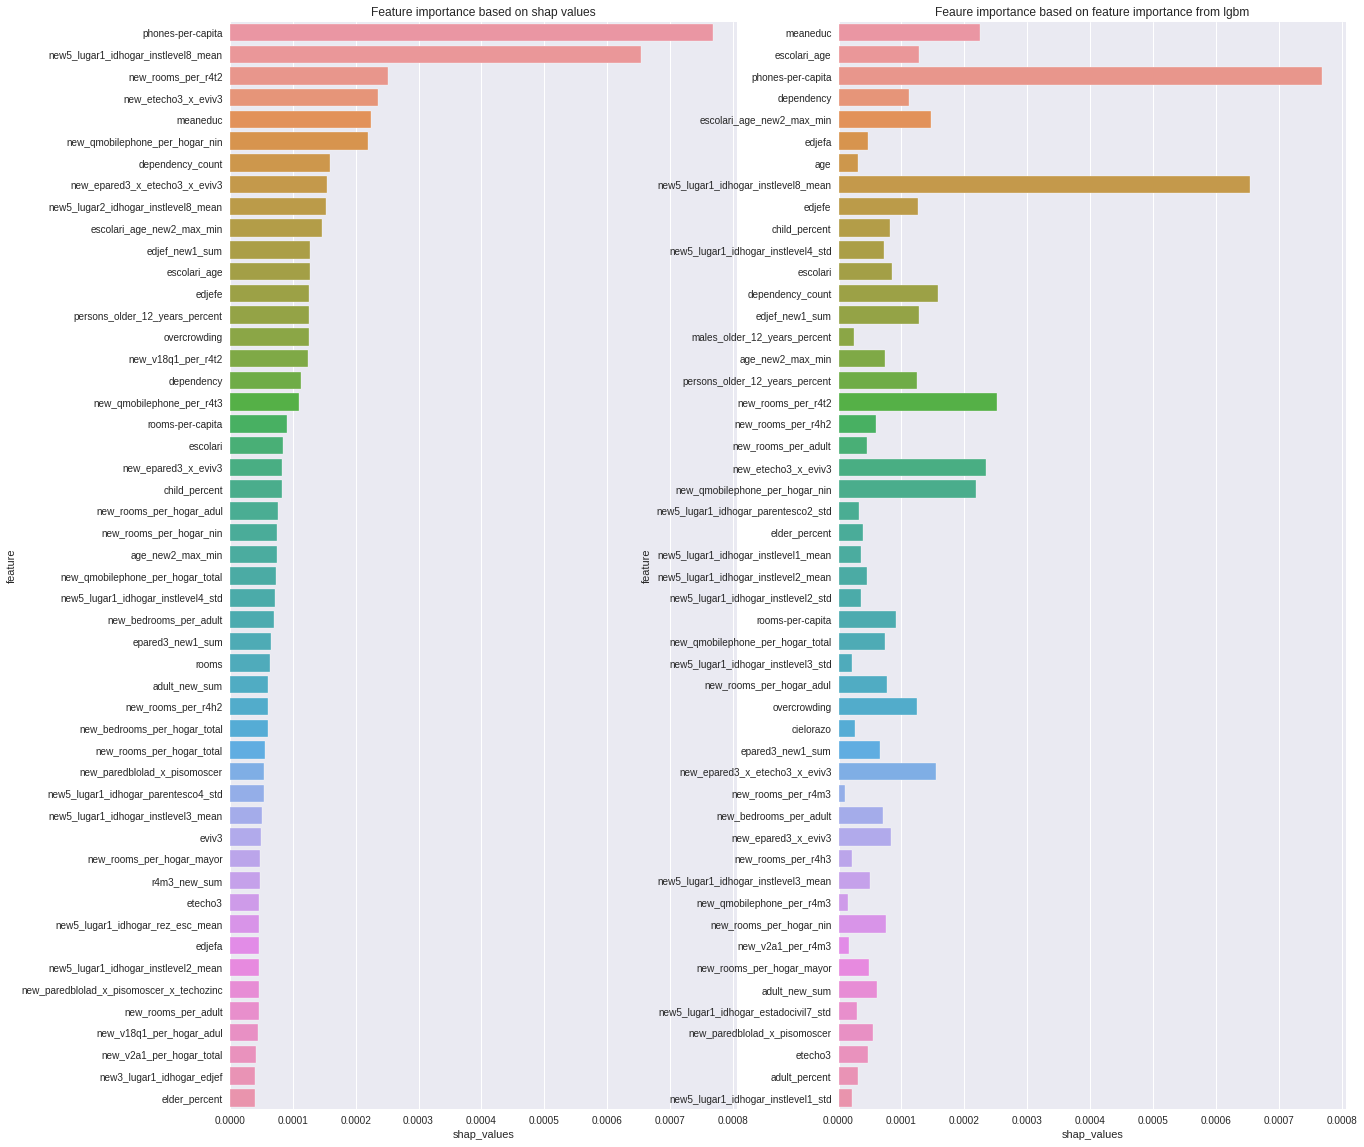

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
feat_importance_df_shap = feat_importance_df.groupby('feature').mean().sort_values('shap_values', ascending=False).reset_index()

num_features = 50
sns.barplot(x=feat_importance_df_shap.shap_values[:num_features], y=feat_importance_df_shap.feature[:num_features], ax=ax[0])
ax[0].set_title('Feature importance based on shap values')

feat_importance_df = feat_importance_df.groupby('feature').mean().sort_values('feat_imp', ascending=False).reset_index()

num_features = 50
sns.barplot(x=feat_importance_df.shap_values[:num_features], y=feat_importance_df.feature[:num_features], ax=ax[1])
ax[1].set_title('Feaure importance based on feature importance from lgbm')
plt.show()

In [0]:
submission['Target'] = np.array(predicts_result).mean(axis=0).round().astype(int)
submission.to_csv('submission_with_new_feature_set.csv', index = False)


4.2 Randomize Search
---



In [0]:
optimized_param = None
lowest_cv = 1000
total_iteration = 100
for i in range(total_iteration):
    print('-'*20, 'For {} of {} iterations'.format(i+1, total_iteration), '-'*20)
    learning_rate = np.random.rand() * 0.02
    n_folds = 3

    num_class = len(np.unique(y))

    params = {}
    params['application'] = 'multiclass'
    params['metric'] = 'multi_logloss'
    params['num_class'] = num_class
    params['class_weight'] = 'balanced'
    params['num_leaves'] = np.random.randint(24, 48)
    params['max_depth'] = np.random.randint(5, 8)
    params['min_child_weight'] = np.random.randint(5, 50)
    params['min_split_gain'] = np.random.rand() * 0.09
    params['colsample_bytree'] = np.random.rand() * (0.9 - 0.1) + 0.1
    params['subsample'] = np.random.rand() * (1 - 0.8) + 0.8
    params['bagging_freq'] = np.random.randint(1, 5)
    params['bagging_seed'] = np.random.randint(1, 5)
    params['reg_alpha'] = np.random.rand() * 2
    params['reg_lambda'] = np.random.rand() * 2
    params['learning_rate'] = np.random.rand() * 0.02
    params['seed']  =1989

    d_train = lgb.Dataset(data=new_train, label=y.values-1, categorical_feature=new_categorical_feats, free_raw_data=False)
    cv_results = lgb.cv(params=params, train_set=d_train, num_boost_round=10000, categorical_feature=new_categorical_feats,
                        nfold=n_folds, stratified=True, shuffle=True, early_stopping_rounds=1, verbose_eval=1000)

    min_cv_results = min(cv_results['multi_logloss-mean'])

    if min_cv_results < lowest_cv:
        lowest_cv = min_cv_results
        optimized_param = params

-------------------- For 1 of 100 iterations --------------------


NameError: ignored

In [0]:
N_Folds = 20
SEED = 1989
predicts_result, feat_importance_df = LGB_OOF(optimized_param, new_categorical_feats, N_Folds, SEED=1989)

In [0]:
submission['Target'] = np.array(predicts_result).mean(axis=0).round().astype(int)
submission.to_csv('submission_shap_randomized_search.csv', index = False)